観測できない不均質さを内包しているデータに対処するために、一般化線形混合モデルを導入したが、ランダム効果の発生源が増えるにしたがって数値的な最尤推定に要する計算時間が長くなったり、最尤推定値の探索そのものが困難になります。

このような複雑な統計モデルの当てはめで威力を発揮するのが、マルコフ連鎖モンテカルロ法（MCMC）である。

あるデータに対してMCMCアルゴリズムを適用すると、推定結果はある確率分布からのランダムなサンプルとして得られる。得られた結果はMCMCサンプルと呼ばれる。

とりあえずは、MCMCアルゴリズムは多変量の確率分布からの巧妙な乱数発生方法であり、統計モデルを観測データに当てはめるとMCMCサンプルが得られると考えてください。

## 8.1種子の生存確率（個体差なし）
各植物個体8個の種子の生死の問題

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = np.array([4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4])

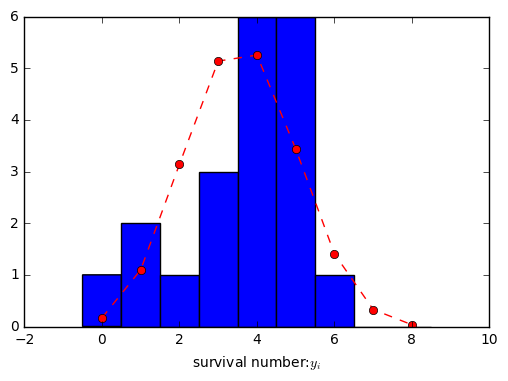

In [2]:
x = np.arange(-0.5,9.5,1.)
x_int = np.arange(0,9,1)
plt.hist(data,bins=x)
plt.plot(x_int,stats.binom.pmf(x_int,8,0.45)*20,'--o',color='r') #真の確率分布
plt.xlabel('survival number:$y_{i}$')
plt.show()

大体二項分布に従っている。二項分布したがっているとの仮定のもと、最大対数尤度の式から微分して簡単にパラメータは求められる。

In [16]:
const = np.ones(data.shape[0])
model = sm.GLM(np.array([data,8-data]).T,const,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                   20
Model:                            GLM   Df Residuals:                       19
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -37.748
Date:                Fri, 03 Feb 2017   Deviance:                       28.722
Time:                        00:06:16   Pearson chi2:                     24.5
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1754      0.159     -1.105      0.269        -0.487     0.136
==============================================================================
"""

In [18]:
q = 1 / (1+np.exp(-result.params[0]))
q

0.45624999999999993

生存確率は0.46程度と推定された。

## 8.2　ふらふら試行錯誤による最尤推定
試行錯誤による最尤推定法では、qをいい加減にきめて、qを振り出しにしてqを増減させながら対数尤度が高くなるqを逐次的に探していきます。

In [25]:
y = np.arange(0.01,1.0,0.01)
log_likeliwoods = np.array([stats.binom.logpmf(data,8,p).sum() for p in y])

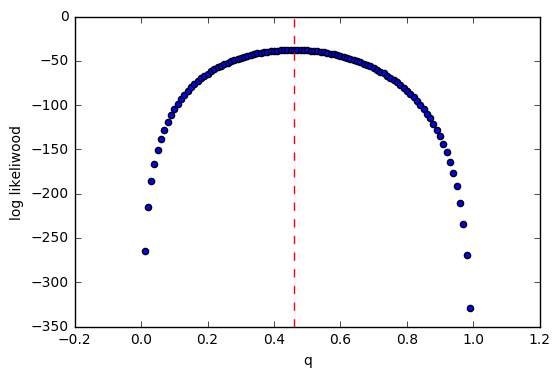

In [26]:
plt.scatter(y,log_likeliwoods)
plt.axvline(y[np.argmax(log_likeliwoods)],c='r',linestyle='--')
plt.xlabel('q')
plt.ylabel('log likeliwood')
plt.show()

In [6]:
print('最大対数尤度のq:%f')%y[np.argmax(log_likeliwoods)]

最大対数尤度のq:0.456513


手順は以下の通り
- qは隣の値にしか変化できないとする
- ランダムに右隣か左隣かを選択し、対数尤度が現在のqよりも高ければそちらに移動する。

In [7]:
np.random.randint(2,size=100)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1])

In [8]:
def series_llf(prob):
    series = [[0,prob]]
    llf = stats.binom.logpmf(data,8,prob).sum()
    for i in range(100):
        random = np.random.randint(2)
        if random==1:
            cal = stats.binom.logpmf(data,8,prob+0.01).sum()
            if llf < cal:
                llf = cal
                prob += 0.01
        else:
            cal = stats.binom.logpmf(data,8,prob-0.01).sum()
            if llf < cal:
                llf = cal
                prob -= 0.01
        series.append([i+1,prob])
    
    return np.array(series)
init_3 = series_llf(0.3)
init_6 = series_llf(0.6)

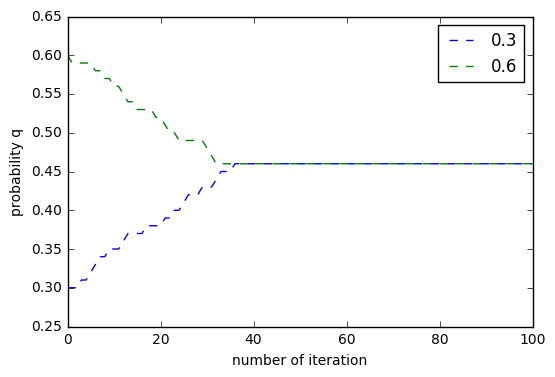

In [9]:
plt.plot(init_3[:,0],init_3[:,1],'--',label='0.3')
plt.plot(init_6[:,0],init_6[:,1],'--',label='0.6')
plt.legend(loc='upper right')
plt.xlabel('number of iteration')
plt.ylabel('probability q')
plt.show()

このようなルールにしたがってqを変化させていくと、とこどころつまづきながらも、qの初期値にかかわりなく、対数尤度の山を登りながらqの最尤推定値の方向に変化していく。

## 8.3 メトロポリス法
MCMCアルゴリズムの中で最も簡単なメトロポリス法を扱う。先ほどの過程に少し手を加えるとメトロポリス法になる。
- パラメータqの初期値を選ぶ
- qを増やすか減らすかをランダムに決める。（新しく選んだqの値をq_newとする）
- q_newにおいて尤度がおおきくなるならqの値をq_newに更新する。
- q_newで尤度が小さくなる場合であっても、確率rでqの値をq_newに更新する。

４つめのルールを追加すると、メトロポリス法になる。なおrは以下の値で設定する。
$$r=\frac{L(q_{new})}{L(q)}$$

この式から明らかなように、尤度比が小さいほど移動しやすいというルールになっている。

MCMCアルゴリズムでは、一つのステップの中で前の状態qに基づいて新しい状態q_newを作り出しているので、マルコフ連鎖になっている。

また、一般に乱数を利用した計算アルゴリズムはモンテカルロ法と呼ばれています。

### 8.3.1メトロポリス法でサンプリングしてみる。

In [10]:
def series_llf_metoro(prob,size):
    llf = stats.binom.logpmf(data,8,prob).sum()
    series = [[0,prob,llf]]
    for i in range(size):
        random = np.random.randint(2)
        if random==1:
            cal = stats.binom.logpmf(data,8,prob+0.01).sum()
            if llf < cal:
                llf = cal
                prob += 0.01
            elif np.random.rand() < np.exp(cal-llf):
                llf = cal
                prob += 0.01
        else:
            cal = stats.binom.logpmf(data,8,prob-0.01).sum()
            if llf < cal:
                llf = cal
                prob -= 0.01
            elif np.random.rand() < np.exp(cal-llf):
                llf = cal
                prob -= 0.01           
        series.append([i+1,prob,llf])
    
    return np.array(series)

init_3_100 = series_llf_metoro(0.3,100)
init_3_1000 = series_llf_metoro(0.3,1000)
init_3_10000 = series_llf_metoro(0.3,10000)

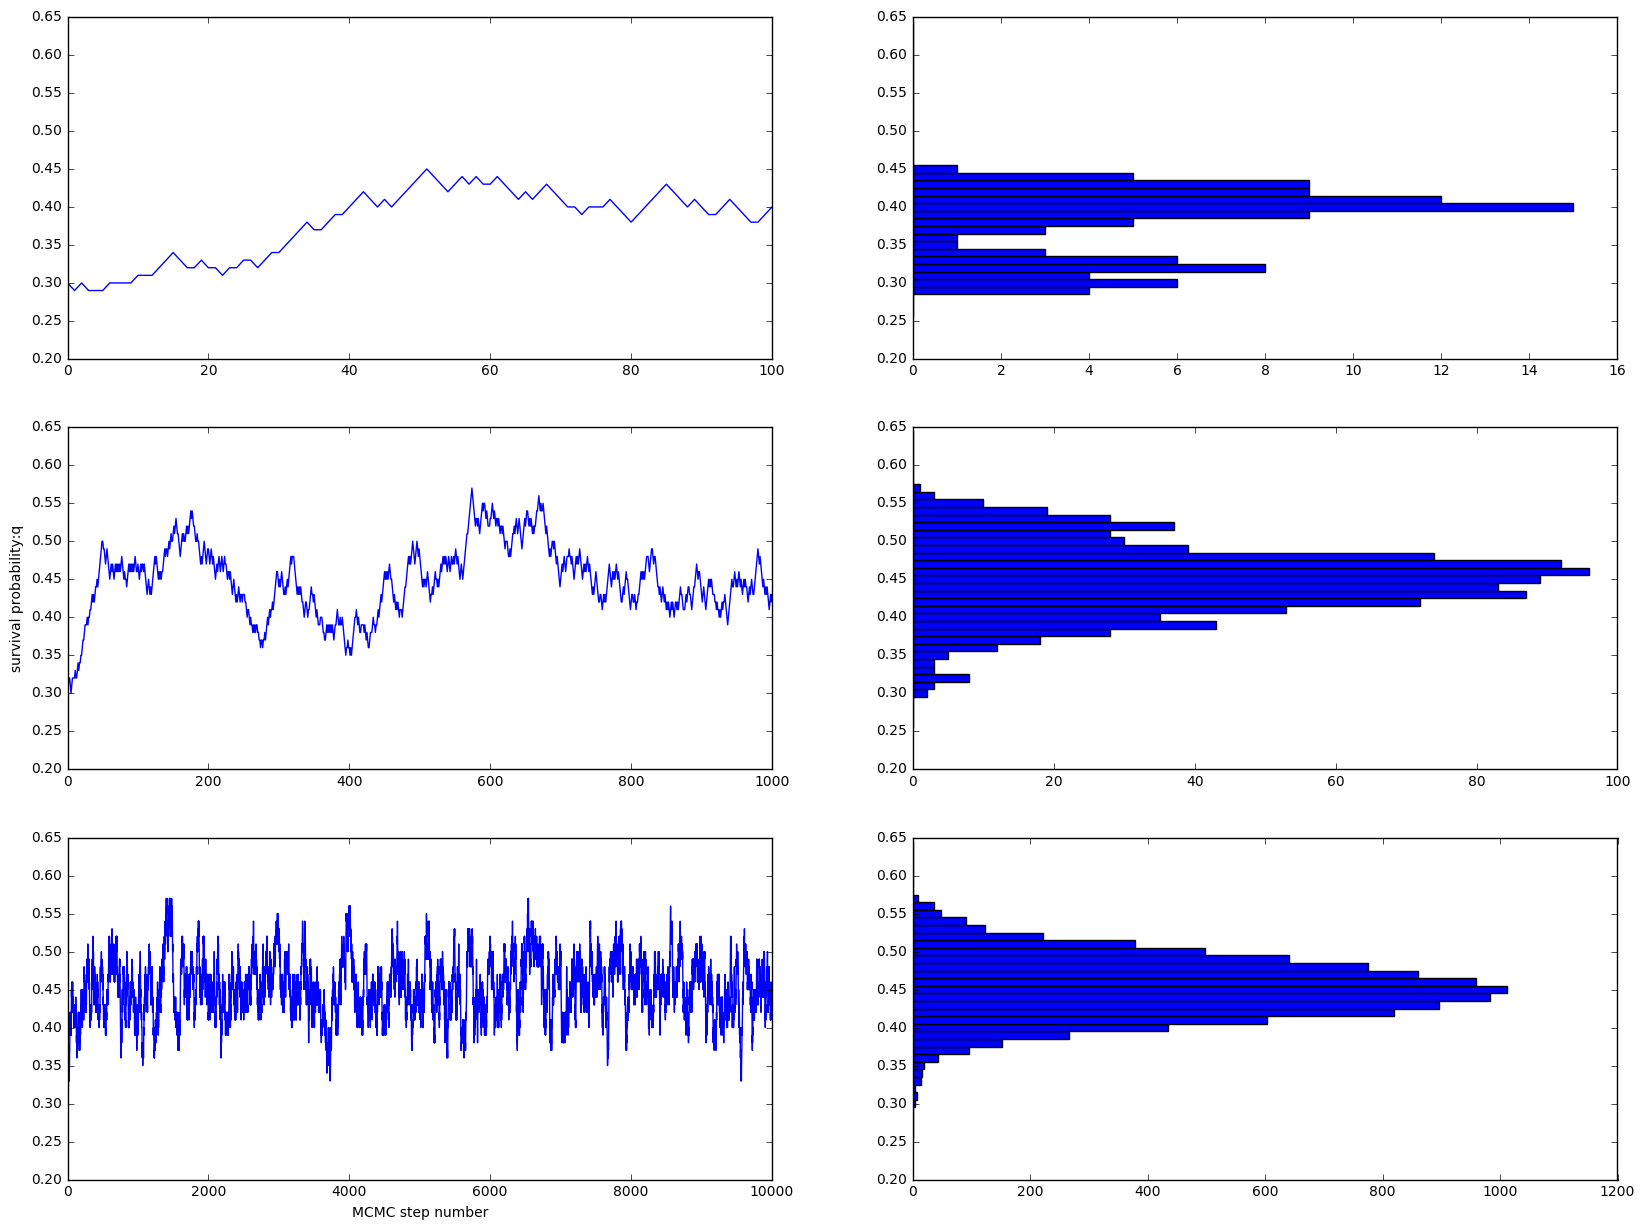

In [11]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(3,2,1)
ax12 = fig.add_subplot(3,2,2)
ax2 = fig.add_subplot(3,2,3)
ax22 = fig.add_subplot(3,2,4)
ax3 = fig.add_subplot(3,2,5)
ax32 = fig.add_subplot(3,2,6)

ax1.plot(init_3_100[:,0],init_3_100[:,1],label='N=100')
ax1.set_ylim((0.2,0.65))
ax12.hist(init_3_100[:,1],bins=np.arange(0.245,0.655,0.01),orientation='horizontal')
ax2.plot(init_3_1000[:,0],init_3_1000[:,1],label='N=1000')
ax2.set_ylim((0.2,0.65))
ax2.set(ylabel='survival probability:q')
ax22.hist(init_3_1000[:,1],bins=np.arange(0.245,0.655,0.01),orientation='horizontal')
ax3.plot(init_3_10000[:,0],init_3_10000[:,1],label='N=10000')
ax3.set_ylim((0.2,0.65))
ax3.set(xlabel='MCMC step number')
ax32.hist(init_3_10000[:,1],bins=np.arange(0.245,0.655,0.01),orientation='horizontal')

plt.show()

対数尤度は増大、あるいはその場に停滞するだけでなく、減少するステップもある。また、一旦対数尤度が最大になるqに達しても、そこからずり落ちるところも異なっている。

最尤推定法の時と違って、どこかにある一番いい値に到達するわけではない。

MCMCアルゴリズムの目的は何か特定の値の探索ではなく、ステップ数とともに変化するパラメータの値の生成です。これをサンプリングと呼ぶ。このようなサンプリングをMCMC法を使った統計モデルの当てはめに相当する。

スッテプ数が増えると、ヒストグラムの形状が確率密度関数に似たものになっていく。この確率分布はこの例題の統計モデルと、メトロポリス法によって決まるマルコフ連鎖の定常分布である。

メトロポリス法の適用によってこの分布からランダムサンプルが得られているようです。

In [12]:
y = np.arange(0.25,0.66,0.01)
log_likeliwoods = np.array([stats.binom.logpmf(data,8,q).sum() for q in y])
likeliwoods = np.exp(log_likeliwoods)
P_q_Y = likeliwoods / likeliwoods.sum()

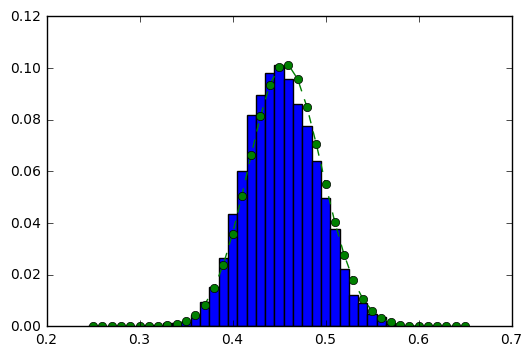

In [13]:
plt.hist(init_3_10000[:,1],bins=np.arange(0.245,0.655,0.01),weights=np.ones(len(init_3_10000[:,1]))*0.0001)
plt.plot(y,P_q_Y,'--o')
plt.show()